In [40]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/(sig * np.sqrt(2) * np.pi)


In [42]:
res = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv", skiprows=11,)
res = res[res.index%2==0]
res = res.loc[[4,6,20,22,24,26,28],]
res

,date,ID,burnin,steps,walkers,nparam,t01_p16,t01_p50,t01_p84,theta_a_p16,...,radius_p16,radius_p50,radius_p84,ED_distr1_p16,ED_distr1_p50,ED_distr1_p84,Eflare1_p16,Eflare1_p50,Eflare1_p84,Unnamed: 33
4,11_02_2020_11_16,237880881a,50000,126742,32,10,1331.66400897832,1331.66405852341,1331.66408293647,13.5378094966208,...,46.8267524633738,53.5025151861576,74.6806472911025,6493.35337741692,9288.3462142352,13454.9483964226,5.76005196768358E+034,8.23940324484771E+034,1.19354665426703E+035,NaN
6,11_02_2020_11_16,237880881b,50000,126742,32,10,1331.82436563852,1331.82462120353,1331.82613215887,40.8909703163573,...,17.1097952600288,19.3717278583333,20.3491014571879,4349.44196217513,5487.60128869995,5992.37039293116,3.85825478398938E+034,4.86788054855767E+034,5.31564553269742E+034,NaN
20,06_03_2020_10_16,100004076,150000,590751,32,6,1358.51221233685,1358.51274040472,1358.51328990776,-14.5867123740818,...,15.8347733112126,20.5015978036307,32.9827966335637,30931.7893387612,46581.3536108787,114778.001837465,3.46292269637279E+033,5.21494650310258E+033,1.28498013242706E+034,NaN
22,08_07_2020_11_48,44984200,150,22156,32,6,1588.02720287295,1588.0274767793,1588.02775393296,67.8097289772427,...,5.19943320880413,5.23847856871522,5.28122245490863,3283.49730651743,3335.05379195772,3391.31640249332,3.05642734579997E+033,3.10441844712972E+033,3.15679022189737E+033,NaN
24,11_02_2020_10_07,237880881a,34903,1576002,32,9,1331.66385326558,1331.66387122321,1331.66388820846,57.8795686074588,...,42.0206628759492,42.2100433396356,42.333080319898,4939.39368169012,4987.5330189568,5031.50265263991,4.38158261867168E+034,4.42428552859035E+034,4.46328962405442E+034,NaN
26,11_02_2020_10_07,237880881b,34903,1576002,32,9,1331.82639427697,1331.82654088914,1331.82668586329,57.8795686074588,...,16.7247046012945,16.7956777286697,16.8856247953146,4689.25209389904,4724.91710976565,4772.26816371612,4.15968979054276E+034,4.19132711764934E+034,4.23333076593805E+034,NaN
28,08_07_2020_11_48,277539431,4000,13992,32,6,1641.84298861174,1641.84468794686,1641.84587247527,81.6654258099708,...,16.4421375885852,18.0613375397592,19.5904159431731,24040.3323722051,28685.3414479151,33452.4064833166,2.70783139821472E+034,3.23103137837564E+034,3.76797937810946E+034,NaN


8.233454192776598 18.7768597015692 237880881a 10
18.435228940449406 5.520870402742801 237880881b 10
68.54299590848396 18.19768945329445 100004076 6
1.3312982085391099 1.4333892454154977 44984200 6
0.31700291694980365 0.5947795658170989 237880881a 9
0.31700291694980365 0.5947795658170989 237880881b 9
0.38683919654909005 0.4626916113293049 277539431 6


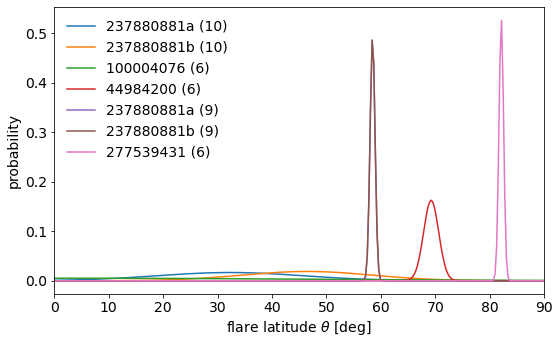

In [48]:
plt.figure(figsize=(8,5))
x = np.linspace(0,90,300)
for i, row in res.iterrows():
    a, up, lo = float(row.theta_a_p50), float(row.theta_a_p84), float(row.theta_a_p16)
    print(up-a,a-lo,row.ID,row.nparam)
    plt.plot(x, gaussian(x,a,(up-lo)/2), label=f"{row.ID} ({row.nparam})")
plt.legend(loc=2, frameon=False)
plt.xlim(0,90)
plt.xlabel(r"flare latitude $\theta$ [deg]")
plt.ylabel(r"probability")
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flare_latitudes.png",dpi=300)

In [21]:
gaussian(x,a,(up-lo)/2)

array([0.])